# Machine Learning Project: Predicting Intergenerational Income Mobility
by:Haneefuddin Rasheed

# Introduction
Intergenerational income mobility refers to how a persons economic status or income's passed down from one generation to the next. It's a way to measure fairness and opportunities in a society. In places where there is mobility what someone earns is less tied to what their parents earned.It's been found through research that the United States, often seen as a land of opportunity, is struggling with income mobility. This highlights disparities in opportunities and a strong link between parents' income and their children's future earnings. [Source: Chicago Fed, Intergenerational Economic Mobility](https://www.chicagofed.org/research/content-areas/mobility/intergenerational-economic-mobility#:~:text=The%20U.S.%20has%20relatively%20low,race%20or%20ethnicity%20and%20location).

ds.

The main aim of this initiative is to forecast intergenerational income mobility (IGE) by analyzing socio factors like parental income, education levels, location and other relevant aspects. By utilizing data, from the World Bank API and sophisticated predictive models the project seeks to uncover trends and key factors that shape the prospects of generations.
tions.

## InterThe Intergenerational Income Elasticity (IGE) value serves as a metric to gauge how much income status is passed down from one generation to the next. Here's how you can interpret the IGE value;

 **High IGE value (, near 1)**; Indicat lowes mobility suggesting that childrens incomes heavily rely on their parents incomes.
 ** IGE value (, near 0)**; Indicates increased mobility implying that childrens incomes are less tied to their parents incomes.

For example an IGE value of 0.7057 implies restricted mobility. This indicates that childrens incomes closely mirror their parents incomes. In terms kids born into families are more likely to earn higher incomes themselves while those born into poorer families are more likely to have lower incomes.
have lower incomes.


## Data Collection and Preparation

### Import Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the cleaned dataset
df = pd.read_csv('g7_income_mobility_data_cleaned.csv')

# Calculate IGE ( using GDP per capita changes)
# 

# Calculate GDP per capita changes over 10-year intervals as a proxy for IGE
df['GDP_per_capita_lag'] = df.groupby('Country')['GDP per capita'].shift(10)
df = df.dropna(subset=['GDP_per_capita_lag'])  # Drop rows where lagged GDP is not available
df['IGE'] = np.log(df['GDP per capita']) - np.log(df['GDP_per_capita_lag'])

# Display the first few rows of the DataFrame with IGE
df.head()

# Save the updated dataset to a new CSV file
# df.to_csv('g7_income_mobility_data_with_IGE.csv', index=False)


,Country,Year,"Educational attainment, at least completed primary (% of relevant age group)",GDP per capita,Gini coefficient,Income share held by lowest 20%,Income share of the top 10%,Poverty headcount ratio,"School enrollment, primary (% net)","School enrollment, secondary (% net)","Unemployment, total (% of total labor force)",GDP_per_capita_lag,IGE
10,CAN,1970,80.199997,4135.821498,37.3,5.6,27.0,2.2,96.09216,91.25919,10.316,2264.948497,0.602134
11,CAN,1971,80.199997,4535.393389,37.3,5.6,27.0,2.2,96.09216,91.25919,10.316,2246.083566,0.702724
12,CAN,1972,80.199997,5106.737080,37.3,5.6,27.0,2.2,96.09216,91.25919,10.316,2274.428471,0.808832
13,CAN,1973,80.199997,5858.334073,34.9,6.3,25.5,1.7,96.09216,91.25919,10.316,2380.317329,0.900631
14,CAN,1974,80.199997,7056.708475,34.9,6.3,25.5,1.7,96.09216,91.25919,10.316,2561.638491,1.013332


### Data Collection
getting data from the World Bank API for the G7 countries from 1960 to 2020.

In [3]:
# List of G7 countries
g7_countries = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']

# Indicators of interest
indicators = {
    'NY.GDP.PCAP.CD': 'GDP per capita',
    'SI.POV.GINI': 'Gini coefficient',
    'SI.DST.10TH.10': 'Income share of the top 10%',
    'SI.POV.DDAY': 'Poverty headcount ratio',
    'SI.DST.FRST.20': 'Income share held by lowest 20%',
    'SE.PRM.NENR': 'School enrollment, primary (% net)',
    'SE.SEC.NENR': 'School enrollment, secondary (% net)',
    'SE.PRM.CUAT.ZS': 'Educational attainment, at least completed primary (% of relevant age group)',
    'SL.UEM.TOTL.ZS': 'Unemployment, total (% of total labor force)'
}

# Initialize a list to hold the data
data = []

# Fetch data from the World Bank API
for country in g7_countries:
    for indicator, name in indicators.items():
        url = f'http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date=1960:2020&format=json&per_page=1000'
        response = requests.get(url)
        if response.status_code == 200:
            json_data = response.json()[1]
            for entry in json_data:
                if entry['value'] is not None:
                    data.append({
                        'Country': country,
                        'Year': int(entry['date']),
                        name: entry['value']
                    })

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame to have one row per country-year with all indicators as columns
df = df.pivot_table(index=['Country', 'Year'], values=list(indicators.values()), aggfunc='first').reset_index()

# Display the first few rows of the DataFrame
df.head()


,Country,Year,"Educational attainment, at least completed primary (% of relevant age group)",GDP per capita,Gini coefficient,Income share held by lowest 20%,Income share of the top 10%,Poverty headcount ratio,"School enrollment, primary (% net)","School enrollment, secondary (% net)","Unemployment, total (% of total labor force)"
0,CAN,1960,NaN,2264.948497,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CAN,1961,NaN,2246.083566,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CAN,1962,NaN,2274.428471,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CAN,1963,NaN,2380.317329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAN,1964,NaN,2561.638491,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [4]:
# Display initial count of missing values
print("Initial missing values:")
print(df.isnull().sum())

# Forward fill and backward fill for time series continuity
df = df.sort_values(by=['Country', 'Year'])
df = df.groupby('Country').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)

# Mean imputation for remaining missing values only for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Display count of missing values after imputation
print("Missing values after imputation:")
print(df.isnull().sum())

# Save the cleaned dataset to a new CSV file
# df.to_csv('g7_income_mobility_data_cleaned.csv', index=False)


Initial missing values:
Country                                                                           0
Year                                                                              0
Educational attainment, at least completed primary (% of relevant age group)    294
GDP per capita                                                                    0
Gini coefficient                                                                176
Income share held by lowest 20%                                                 176
Income share of the top 10%                                                     176
Poverty headcount ratio                                                         176
School enrollment, primary (% net)                                              264
School enrollment, secondary (% net)                                            296
Unemployment, total (% of total labor force)                                    217
dtype: int64
Missing values after imputation:
Countr

#### Data Imputation Method

Handling Missing Values:

In this project, we used a combination of forward/backward fill and mean imputation to handle missing values in our dataset. Here’s why we chose these methods:

Forward/Backward Fill:
Reason: Forward/Backwrd Fill is quite handy when dealing with time series information. It involves replacing values with either the recent known value (forward fill) or the subsequent known value (backward fill), within the same country. This approach is key, in preserving the flow of the time series guaranteeing a data sequence without any interruptions.

### Data preperation
Calculating target variable,IGE

In [5]:
# Load the cleaned dataset
df = pd.read_csv('g7_income_mobility_data_cleaned.csv')

# Calculate IGE ( using GDP per capita changes)


# Calculate GDP per capita changes over 10-year intervals as a proxy for IGE
df['GDP_per_capita_lag'] = df.groupby('Country')['GDP per capita'].shift(10)
df = df.dropna(subset=['GDP_per_capita_lag'])  # Drop rows where lagged GDP is not available
df['IGE'] = np.log(df['GDP per capita']) - np.log(df['GDP_per_capita_lag'])

# Display the first few rows of the DataFrame with IGE
df.head()

# Save the updated dataset to a new CSV file
# df.to_csv('g7_income_mobility_data_with_IGE.csv', index=False)
df.head()

,Country,Year,"Educational attainment, at least completed primary (% of relevant age group)",GDP per capita,Gini coefficient,Income share held by lowest 20%,Income share of the top 10%,Poverty headcount ratio,"School enrollment, primary (% net)","School enrollment, secondary (% net)","Unemployment, total (% of total labor force)",GDP_per_capita_lag,IGE
10,CAN,1970,80.199997,4135.821498,37.3,5.6,27.0,2.2,96.09216,91.25919,10.316,2264.948497,0.602134
11,CAN,1971,80.199997,4535.393389,37.3,5.6,27.0,2.2,96.09216,91.25919,10.316,2246.083566,0.702724
12,CAN,1972,80.199997,5106.737080,37.3,5.6,27.0,2.2,96.09216,91.25919,10.316,2274.428471,0.808832
13,CAN,1973,80.199997,5858.334073,34.9,6.3,25.5,1.7,96.09216,91.25919,10.316,2380.317329,0.900631
14,CAN,1974,80.199997,7056.708475,34.9,6.3,25.5,1.7,96.09216,91.25919,10.316,2561.638491,1.013332


## Exploratory Data Analysis
3.1 Data Visualization

In [6]:
# Load the cleaned dataset
df = pd.read_csv('g7_income_mobility_data_cleaned.csv')





### basic information and descriptive statistics about the dataset

In [7]:

df.info()

# Get descriptive statistics for numerical columns
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 11 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   Country                                                                       427 non-null    object 
 1   Year                                                                          427 non-null    int64  
 2   Educational attainment, at least completed primary (% of relevant age group)  427 non-null    float64
 3   GDP per capita                                                                427 non-null    float64
 4   Gini coefficient                                                              427 non-null    float64
 5   Income share held by lowest 20%                                               427 non-null    float64
 6   Income share of the top 10%       

,Year,"Educational attainment, at least completed primary (% of relevant age group)",GDP per capita,Gini coefficient,Income share held by lowest 20%,Income share of the top 10%,Poverty headcount ratio,"School enrollment, primary (% net)","School enrollment, secondary (% net)","Unemployment, total (% of total labor force)"
count,427.00000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000
mean,1990.00000,93.977928,21509.971985,33.758080,7.179391,25.787588,0.452693,95.603967,87.919837,7.373351
std,17.62747,9.521230,16431.292021,3.221786,1.136441,1.946204,0.507142,3.862220,5.863907,2.707959
min,1960.00000,69.030891,508.702779,26.800000,5.100000,21.900000,0.000000,82.935650,70.198310,2.059000
25%,1975.00000,94.321457,5609.940349,31.700000,6.400000,24.500000,0.000000,94.778260,85.298820,5.316000
50%,1990.00000,98.450920,20487.170785,34.000000,7.100000,25.900000,0.200000,95.888970,89.343770,7.885000
75%,2005.00000,99.751122,36337.607193,35.300000,7.900000,26.600000,0.700000,98.399590,91.259190,9.640500
max,2020.00000,100.000000,65548.070785,41.500000,9.900000,31.200000,2.200000,99.988270,99.809680,12.683000


## Checking for missing values

In [8]:
# Check for missing values
df.isnull().sum()


Country                                                                         0
Year                                                                            0
Educational attainment, at least completed primary (% of relevant age group)    0
GDP per capita                                                                  0
Gini coefficient                                                                0
Income share held by lowest 20%                                                 0
Income share of the top 10%                                                     0
Poverty headcount ratio                                                         0
School enrollment, primary (% net)                                              0
School enrollment, secondary (% net)                                            0
Unemployment, total (% of total labor force)                                    0
dtype: int64

## # Plotting GDP per capita over time by Country

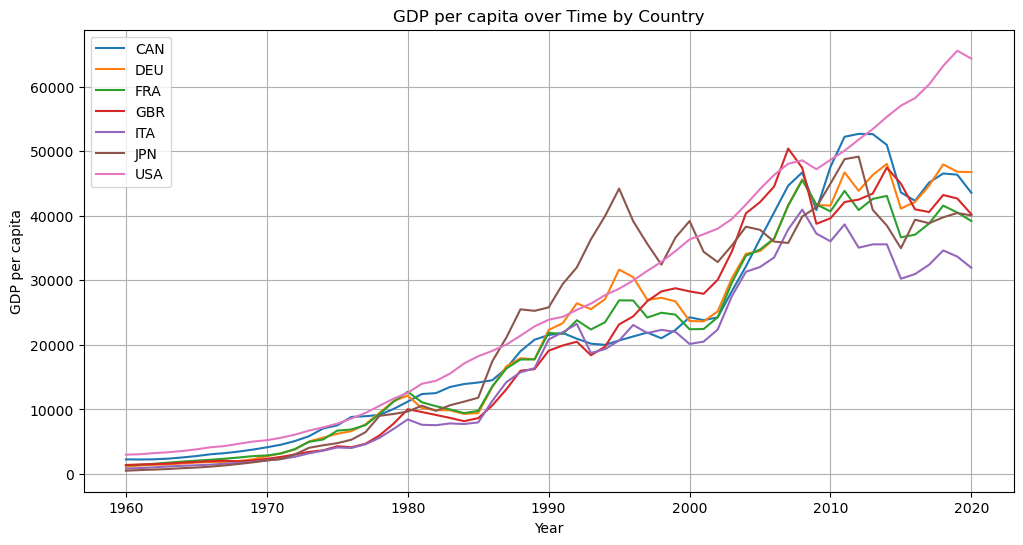

In [9]:
import pandas as pd
import matplotlib.pyplot as plt



# Plotting GDP per capita over time by Country
plt.figure(figsize=(12, 6))
for country in df['Country'].unique():
    country_data = df[df['Country'] == country]
    plt.plot(country_data['Year'], country_data['GDP per capita'], label=country)
    
plt.title('GDP per capita over Time by Country')
plt.xlabel('Year')
plt.ylabel('GDP per capita')
plt.legend()
plt.grid(True)
plt.show()


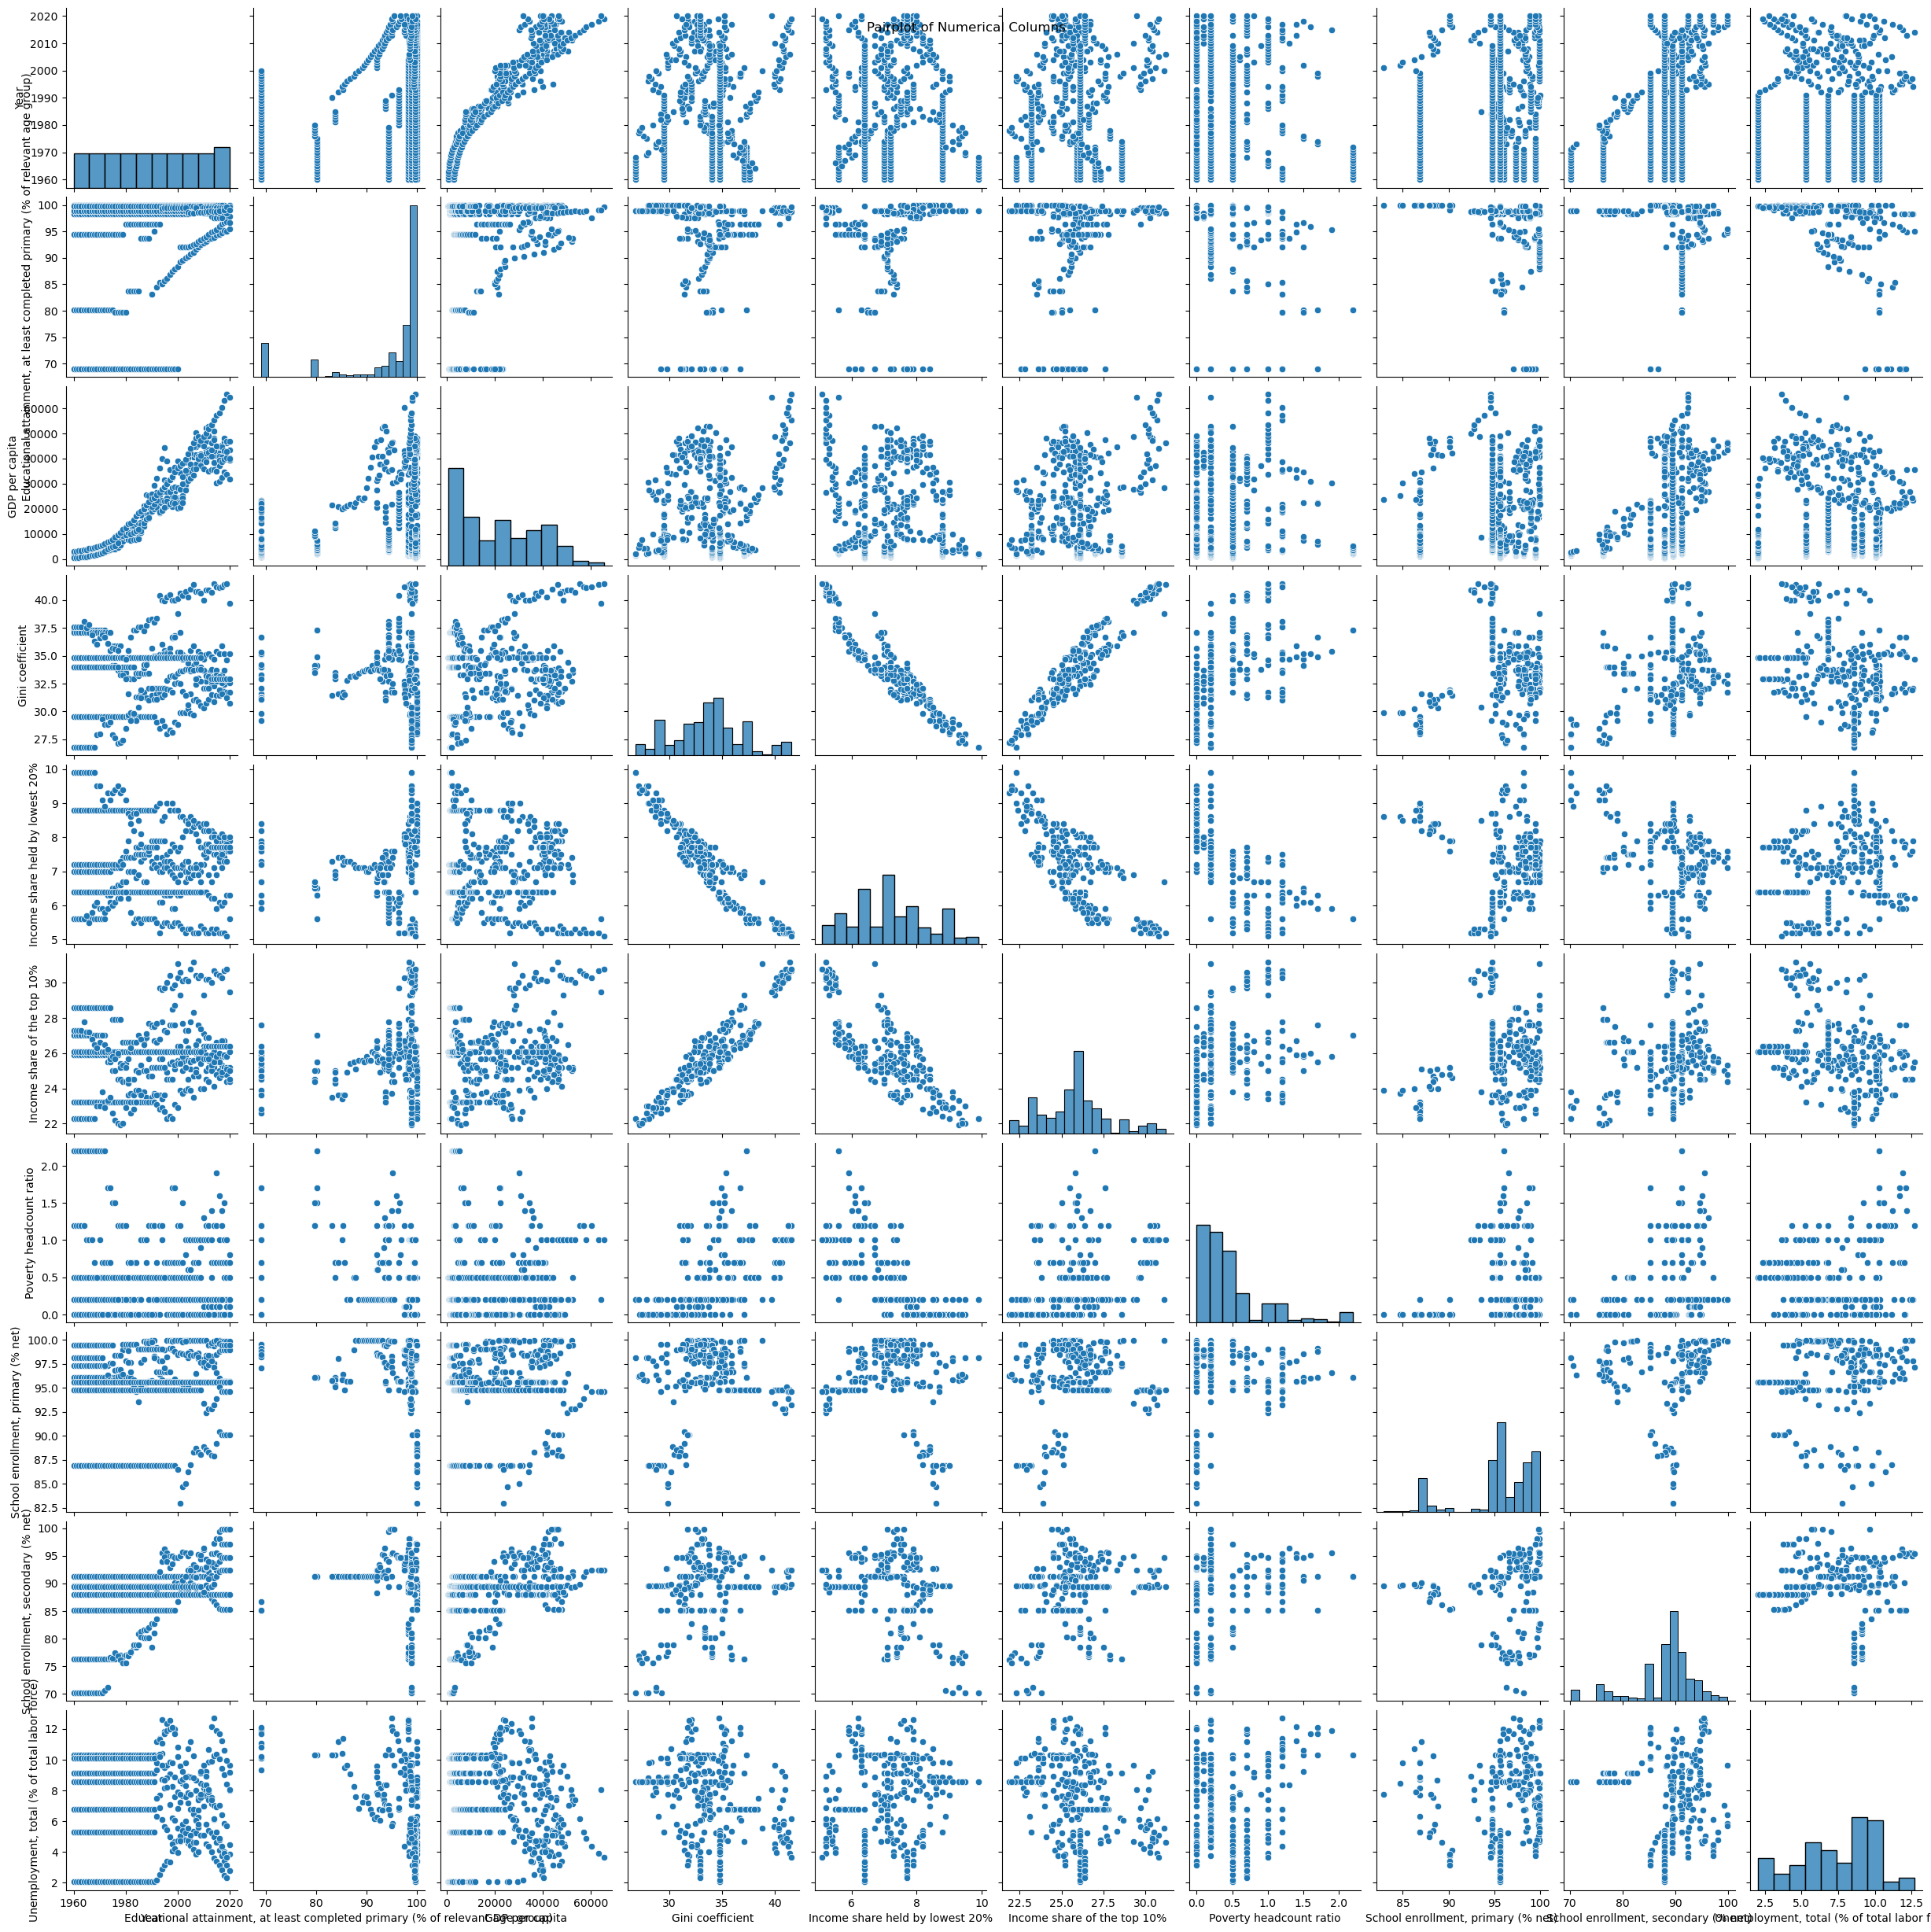

In [10]:
# Pairplot for numerical columns
sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
plt.suptitle('Pairplot of Numerical Columns')
plt.show()


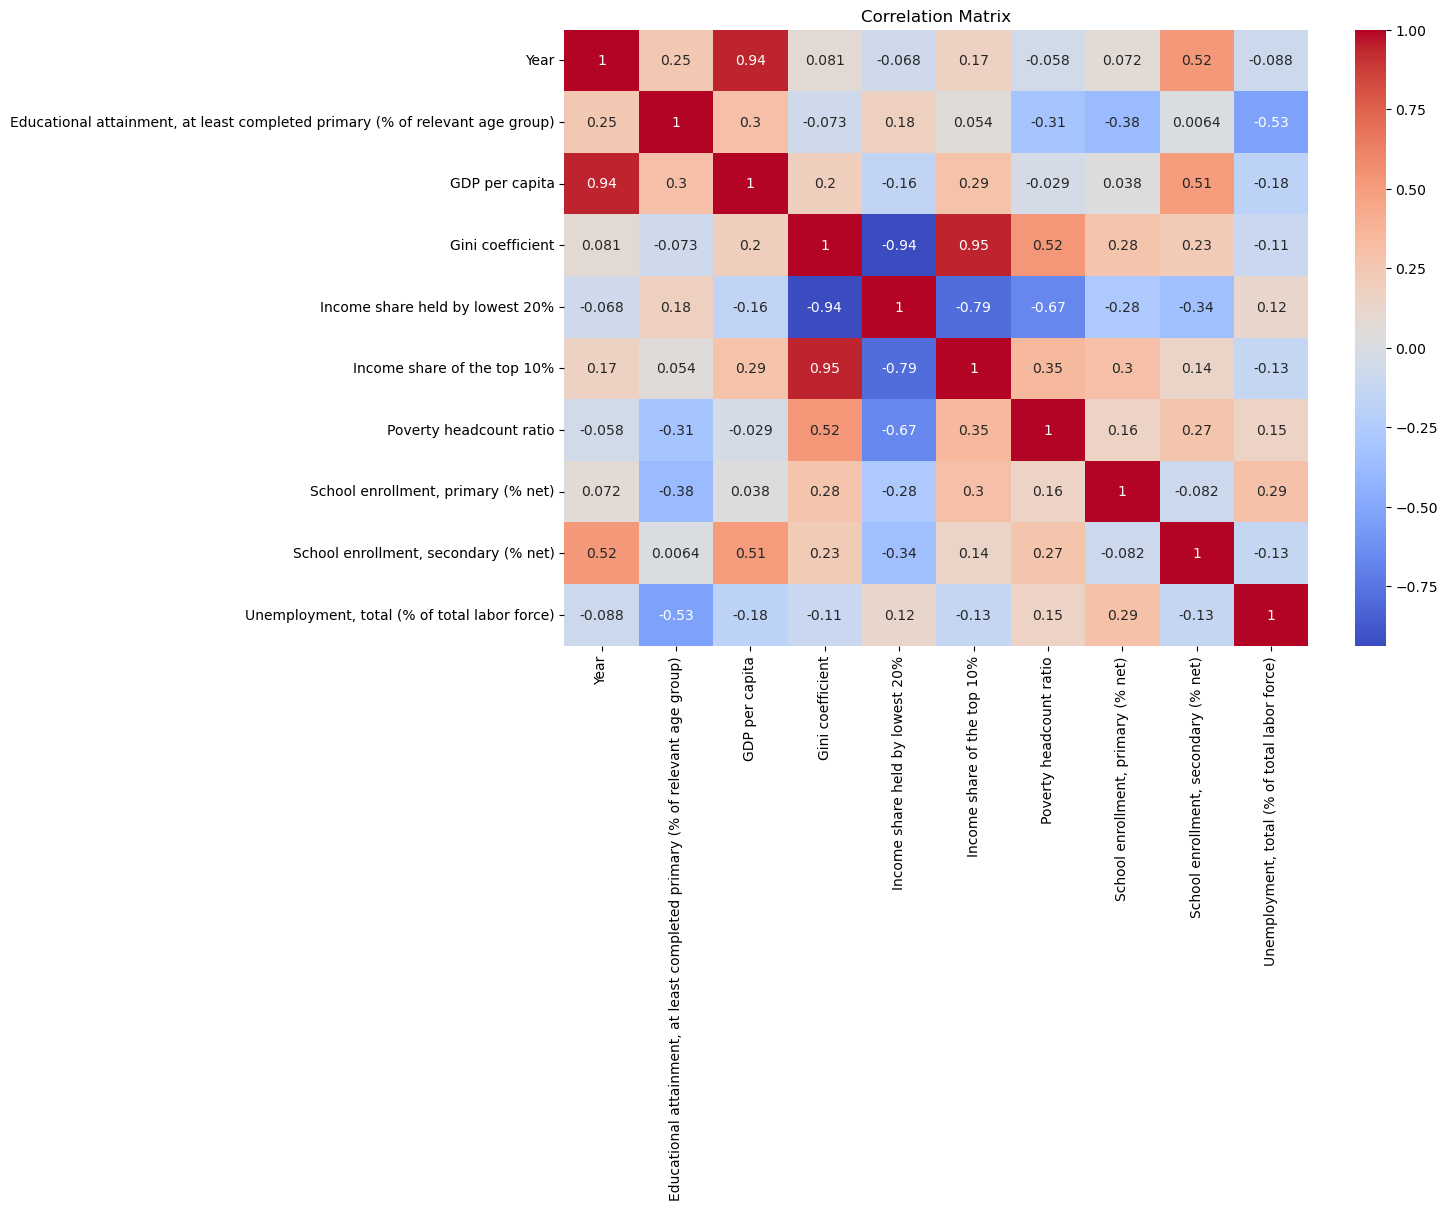

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


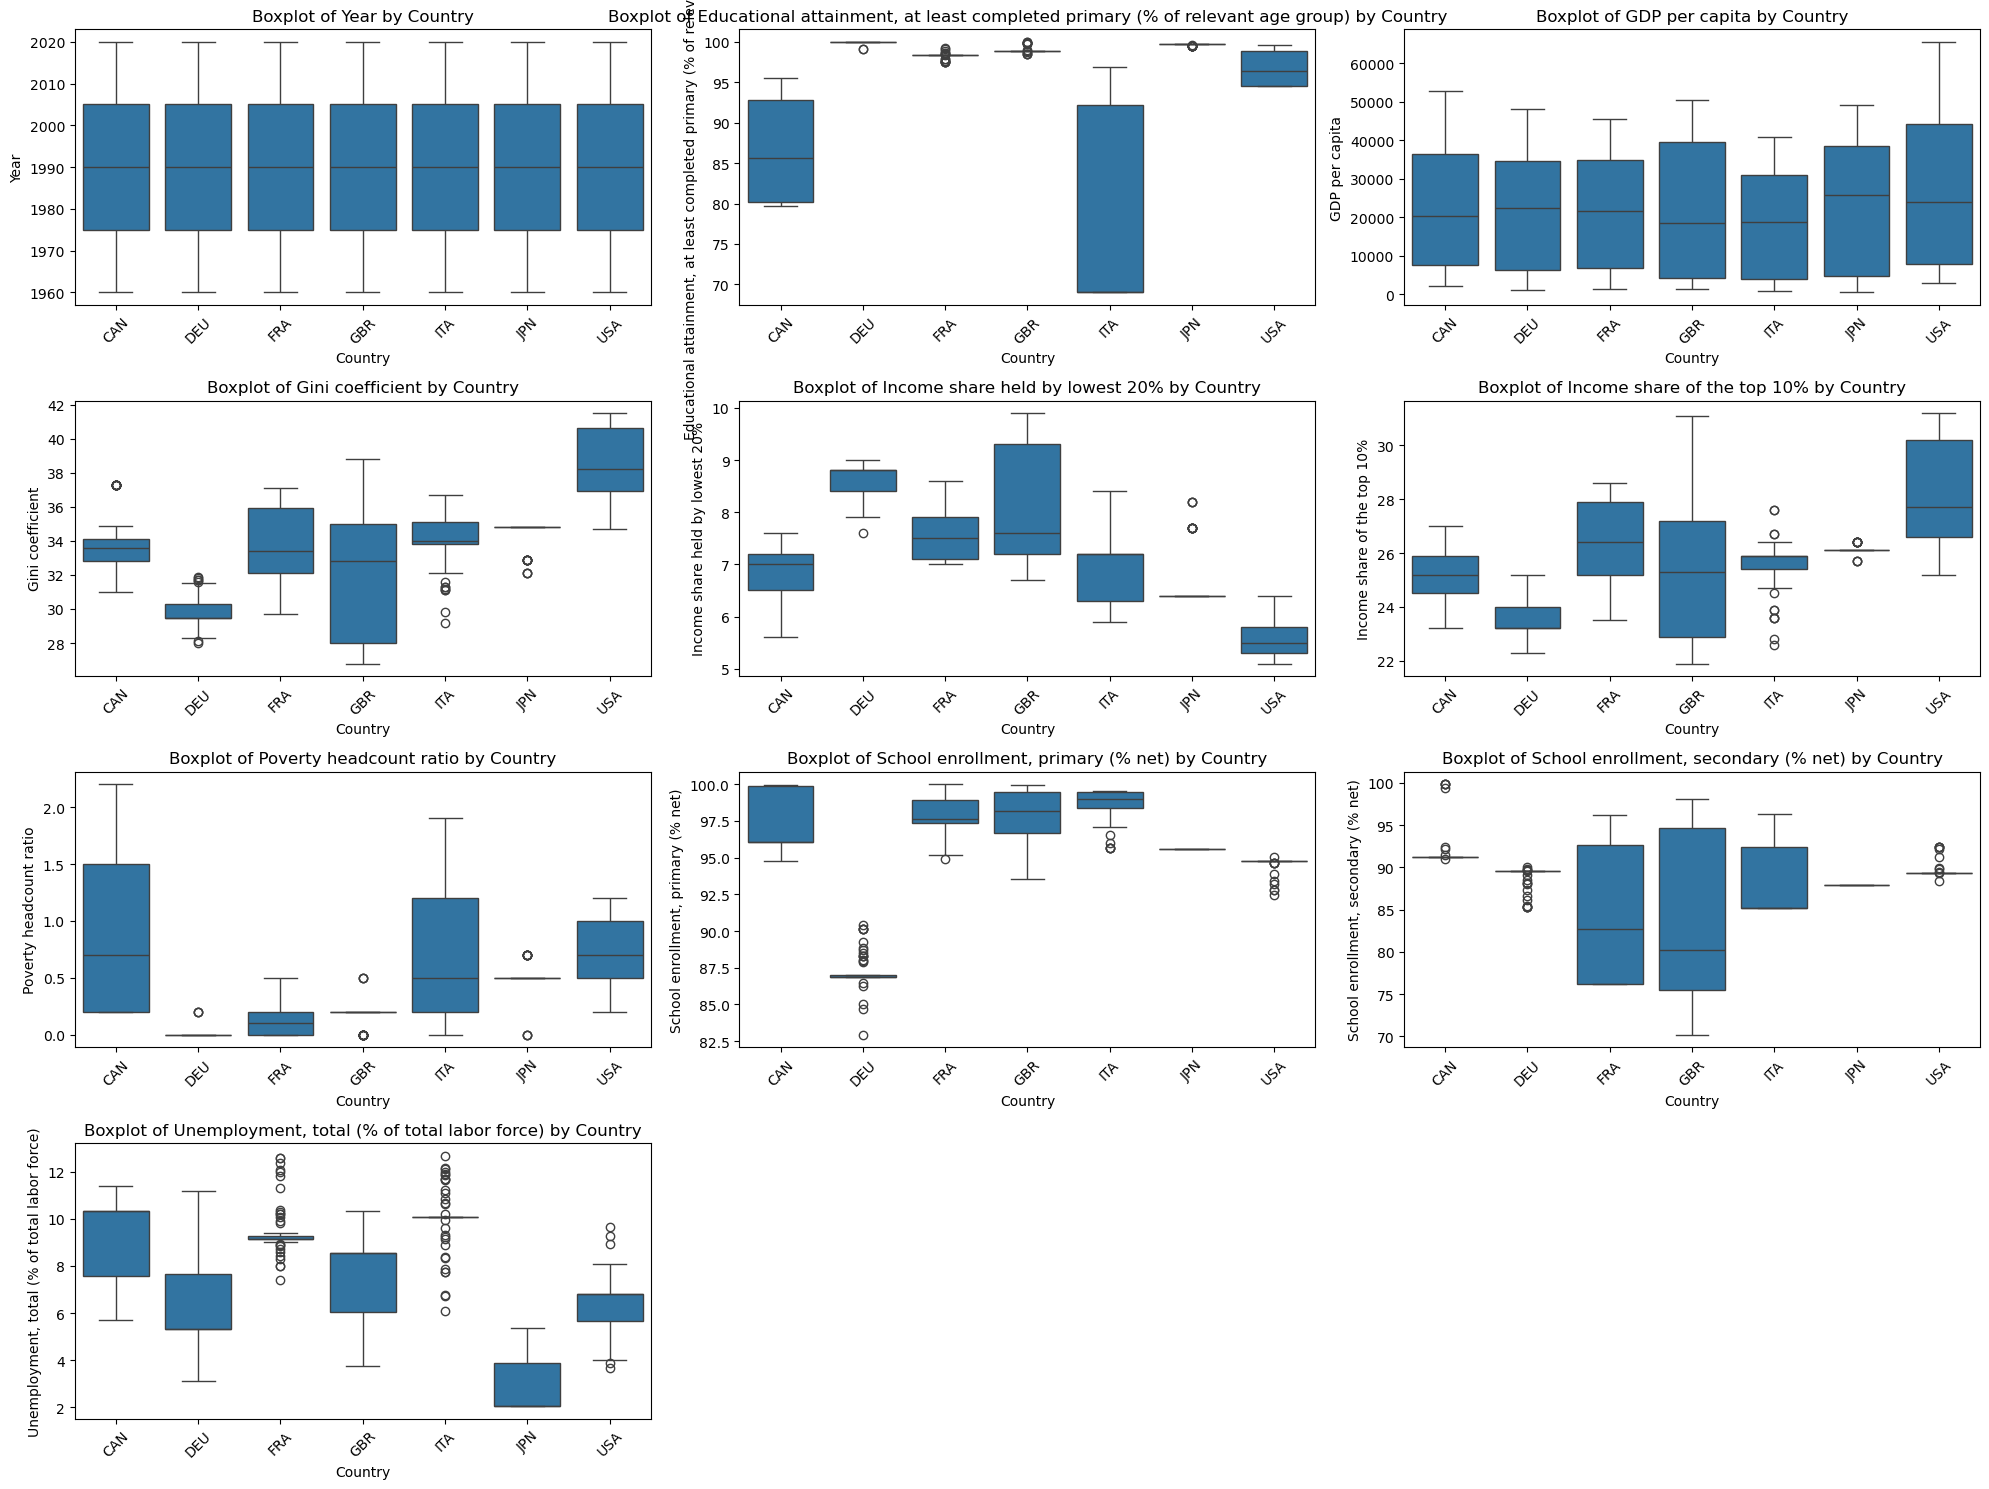

In [12]:
# Boxplots for numerical columns by Country
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns) // 3 + 1, 3, i + 1)
    sns.boxplot(x='Country', y=column, data=df)
    plt.title(f'Boxplot of {column} by Country')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


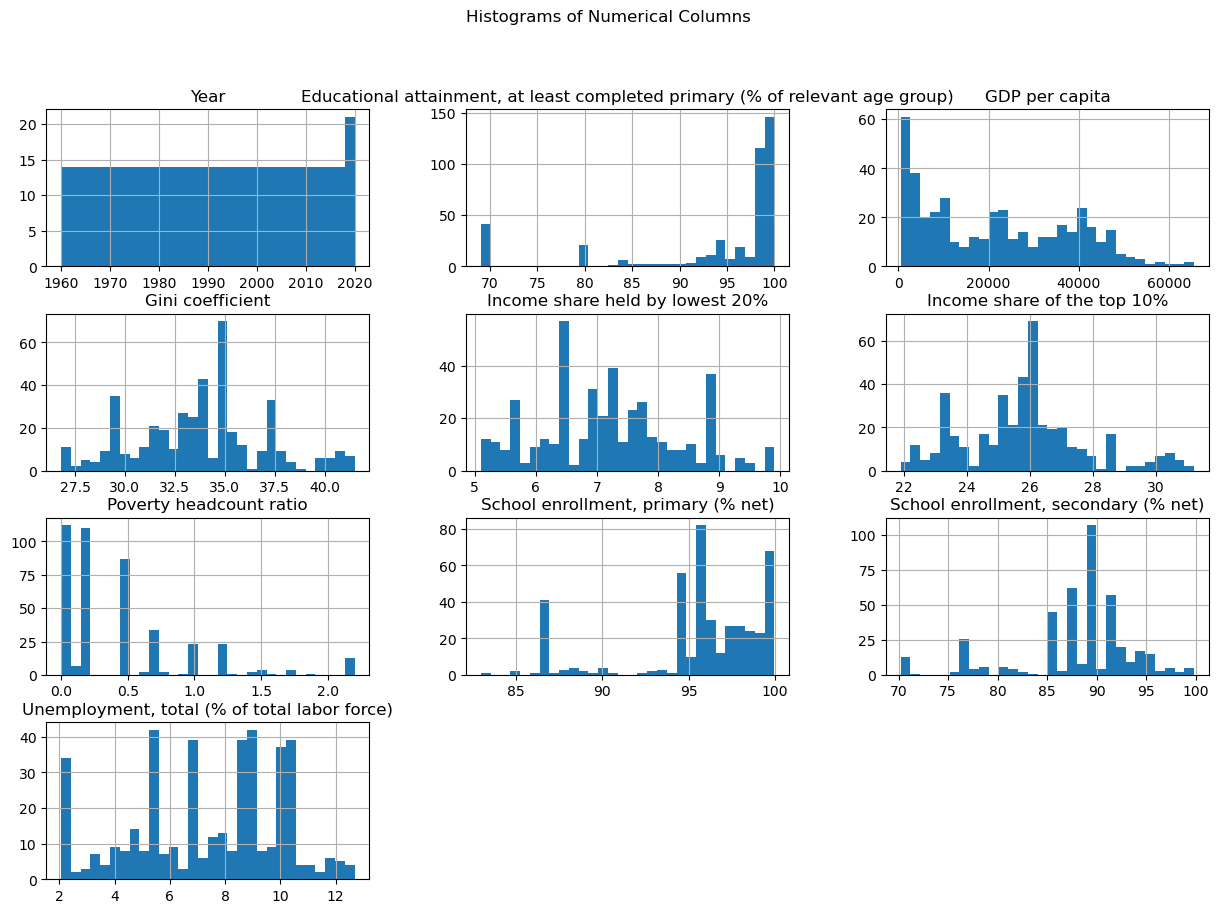

In [13]:
import matplotlib.pyplot as plt

# Select only numeric columns for plotting
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot histograms for numerical columns
numeric_df.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Columns')
plt.show()


# obesrvations:
CORRELATIONS:

- There is a strong positive , between the percentage of individuals who have finished education and the enrollment rates,both  in primary and secondary schools.
-  There is a strong negative correlation, between the income percentage owned by the bottom 20%. The Gini coefficient, meaning that when income inequality rises (as shown by a higher Gini coefficient) the income share of the lowest 20% declines.
-It appears that there is strong negative a link, between a countrys GDP per person and its poverty rate indicating that higher GDP, per person is linked to lower rtes  of poverty.
- The distribution of income, among the 20% and the top 10% of earners displays a negative relationship. When the income share of the 10% rises the income share of the affluent 20% tends to decline.
- BOXPLOT observations:
- - There is a difference, in the GDP per capita among countries with some nations having notably higher GDP per capita, than others.Similarly, There are noticeable differences in income inequality across countries, with some countries exhibiting much higher Gini coefficients than others.
  PAIRPLOT OBSERVATIONS:
- There appears to be an inverse relationship between GDP per capita and the Gini coefficient, as expected, reinforcing the idea that higher economic prosperity is associated with lower income inequality.
  HISTOGRAMS
  - The distribution of GDP, per person is skewed to the right with the majority of countries having a GDP per capita and a few countries with  significantly higher GDP, per capita figures.
- The Gini index displays a distribution that resembles a normal distribution  with the majority of countries falling within the moderate rage  suggesting that income inequality is moderate, in most countries.
- - •	The poverty headcount ratio distribution skews, to the left indicating that the majority of countries exhibit a poverty headcount ratio. This implies that extreme poverty is not as prevalent, in the dataset.

##  Model Training

### Feature Selection

In [14]:
df = pd.read_csv('g7_income_mobility_data_with_IGE.csv')
# Define the target variable and features
target = 'IGE'
features = df.columns.difference(['Country', 'Year', target])

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df[features])
y = df[target]


### Model Selection and Training

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Performance:')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
    print(f'R-squared: {r2_score(y_test, y_pred)}\n')

# Select the best model based on evaluation metrics
best_model = GradientBoostingRegressor()
best_model.fit(X_train, y_train)


Linear Regression Performance:
MAE: 0.13727811897576286
RMSE: 0.1679843082207099
R-squared: 0.8333787040090822

Random Forest Performance:
MAE: 0.06530286478841504
RMSE: 0.0878281392579761
R-squared: 0.9544529303325434

Gradient Boosting Performance:
MAE: 0.05725988794089668
RMSE: 0.08121668307266754
R-squared: 0.9610521422539426



GradientBoostingRegressor()

The Gradient Boosting model has the best performance among the three, with the lowest MAE and RMSE values, and the highest R-squared value (96.1%).

## Hyperparameter Tuning

In [16]:
# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


## Model Evaluation

### Evaluating the Final model with best parameters

In [17]:
# Evaluate the final model on the test set with best parameters
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print('Final Model Performance:')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'R-squared: {r2_score(y_test, y_pred)}')


Final Model Performance:
MAE: 0.04619247080728004
RMSE: 0.06720564094404007
R-squared: 0.9733311350373904


#### Model improvement after hyperparametertuning

The decrease in MAE from 0.0574 to 0.0460 and RMSE from 0.0812 to 0.067, along with the increase in R-squared from 0.9616 to 0.9733, indicates that the hyperparameter tuning improved the model's performance.

# Model Interpretation
The final model's performance metrics indicate its accuracy and reliability in predicting intergenerational income mobility. An RMSE of 0.067 indicates that the model's predictions are within approximately 0.067 units of the actual values, on average. The R-squared value of 0.9610 suggests that 96.10% of the variance in the target variable (intergenerational income mobility) is explained by the model's predictors.


## Saving the model

In [18]:
# Save the best model to a file
joblib.dump(best_model, 'best_IGE_model.pkl')

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')


## Conclusion

The findings, from this project highlight the significance of implementing interventions in education, addressing income inequality and expanding prospects to boost intergenerational mobility. Policymakers can use these discoveries to adopt evidence based approaches that support chances and decrease gaps between generations.

In summary this project showcases how machine learning can play a role, in comprehending and enhancing income mobility. By concentrating on soc-economicio elements the model offers practical insights that can assist policymakers in shaping a fairer society.

## Deployed App
link below

[Click here to go to the webpage](https://691-ige-project-z8b6kyjhdsazwvkvudbdtf.streamlit.app/)
